In [1]:
print('Last updated on', end=' ')
!date

Last updated on Thu Sep 19 11:05:40 PDT 2019


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code.">
</form>''')

# Bayesian Neural Network with Tensorflow 2 and Tensorflow Probability

**Author: Arthur Lui**

This notebook provides an introduction to Tensorflow 2 and tensorflow probability.
The documentation and examples provide a lot of details. However, some of the inner-workings
were not immediately apparent to me. (Things like `DistributionLambda`, `Independent`, and the
`DenseVariational`.) So, I hope to provide more details here.

In [3]:
print('Last updated on', end=' ')
!date

Last updated on Thu Sep 19 11:05:40 PDT 2019


In [4]:
# Libraries for this notebook 
import sys

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tqdm import trange

In [5]:
# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

## Helper Functions

Here are a few helper functions for this tutorial. It may make more sense 
to skip these for now and revisit when you see them being used later.

###  Useful resources:
- [Softplus][1]
- Source to [DenseVariational][2] layer
- Intro to automatic differentiation variational inference ([ADVI][3])
- [Tensorflow probability regression with probablistic layers][4]
- [`tfd.Independent`][5]
- [`DistributionLambda`][6]
- [Writing custom layers and models in TF2][7]

[1]: https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Softplus
[2]: https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/layers/dense_variational_v2.py
[3]: https://luiarthur.github.io/statorial/varinf/introvi/
[4]: https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb
[5]: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Independent
[6]: https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DistributionLambda
[7]: https://www.tensorflow.org/beta/guide/keras/custom_layers_and_models

In [6]:
# This function is used to transform parameters with real support
# to have positive support. This is an alternative to exponentiating.
def centered_softplus(x, c=np.log(np.expm1(1.)), eps=1e-5):
    """
    `softplus(x)` = $\log(1 + \exp(x))$ can be thought of as a smooth reLU.
    The centered softplus simply ensures that the returned values is not
    only always positive, but also "centered" in the sense that 
    `centered_softplus(0) = 1`. This function is useful for transforming
    a parameter with real support to a parameter positive support.
    Exponentiating can be numerically unstable, making the  centered 
    softplus a good alternative.
    """
    return tf.nn.softplus(c + x) + eps


# This function is used to compute the loss function (ELBO).
def neg_loglike(y, rv_y):
    """
    Compute negative log likelihood given a value (y)
    and the distribution (rv_y) of y.
    
    Arguments:
    ==========
    y: A realization from the random variable `rv_y`
    rv_y (tfp.distributions.Distribution): A random variable.
    
    Return:
    =======
    Normalized negative of the log likelihood evaluated at `y`
    """
    return -tf.reduce_mean(rv_y.log_prob(y))


# This is used in DenseVariational, and creates a prior distribution
# for weights and biases in the neural network. 
def make_default_dense_prior(kernel_size, bias_size=0, dtype=None,
                             prior_mean=0, prior_sd=100):
    """
    Make default priors for a dense variational layer.
    """
    # NOTE: `kernel_size` is expected to be the product of
    # the input dimension and number of units in the layer.
    # Therefore, n is the total number of parameters in the
    # dense layer.
    n = kernel_size + bias_size
    
    # mu is the prior mean, represented as a vector
    mu = [prior_mean] * n
    
    # NOTE:
    # The essence of the return is a Normal distribution.
    # The Independent class is a light wrapper, which when 
    # used with the `reinterpreted_batch_ndims=1` argument, 
    # makes the resulting instance a multivariate normal.
    # This is useful because now calling `_.log_prob(x)`
    # will return a scalar, instead of a vector which needs
    # to be summed.
    # `DistributionLambda` is also a light wrapper for distributions.
    # It enables the wrapped distribution to be represented by 
    # a random draw. Note here, because the prior is not affected 
    # by any other input, the lambda provided disregards the input. 
    return tfp.layers.DistributionLambda(lambda _: tfd.Independent(
        tfd.Normal(loc=mu, scale=prior_sd),
        reinterpreted_batch_ndims=1))


# This is used in DenseVariational, and creates a variational distribution
# (guide) for weights and biases in the neural network. 
def make_default_dense_guide(kernel_size, bias_size=0, dtype=None):
    # NOTE: `kernel_size` is expected to be the product of
    # the input dimension and number of units in the layer.
    # Therefore, n is the total number of parameters in the
    # dense layer.
    n = kernel_size + bias_size
    
    # Sequential layers, as used in keras.
    return tf.keras.Sequential([
        # Construct some trainable variational parameters
        # of the appropriate data type.
        # `VariableLayer(2*n)(None)` returns a length 2xn 
        # vector of zeros, which are trainable.
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        # `DistributionLambda` is also a light wrapper for distributions.
        # It enables the wrapped distribution to be represented by 
        # a random draw. Note here, the input is the variational
        # parameters, a 2xn tensor (1-dimensional), and they
        # are split into mean and sd parameters.
        tfp.layers.DistributionLambda(lambda var_params:
            tfd.Independent(
                # Note that the variational distribution
                # is Normal, and the mean and variance
                # are being learned. There are as many 
                # mean and variances as the are parameters.
                tfd.Normal(loc=var_params[:n],
                           scale=centered_softplus(var_params[n:])),
                reinterpreted_batch_ndims=1
            )
        ),
    ])

# See the following demo of the behavior of some of the layers used.

##  `VariableLayer`

Note that an instance of `VariableLayer` returns a trainable layer of zeros.
After instantiation, it is ignostic to the input.

In [7]:
# Instantiate a variable layer
variable_layer = tfp.layers.VariableLayer(10)

# Note that the created object is ignostic to the input.
# It always returns a tensor of zeros, of length 10.
# This tensor is trainable.
print(variable_layer([1,2,3]))
print(variable_layer(None))
print(variable_layer(1))
print(variable_layer('abc'))

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


###  `tfd.Independent`



In [8]:
# Create two random variables z, which have
# mean [-1, 1] and sd [.1, .5] respectively
z = tfd.Normal(loc=[-1., 1], scale=[0.1, 0.5])

# Group the two random variables into one RV,
# effectively making it a multivariate normal 
# distribution with independence between each component.
# `reinterpreted_batch_ndims` defaults to 0, in which
# case `Independent(z) = z`. Changing `reinterpreted_batch_ndims=1`
# causes the grouping.
ind = tfd.Independent(z, reinterpreted_batch_ndims=1)

# Note the differences in the interpreted shapes
print('z.batch_shape: {}'.format(z.batch_shape))
print('ind.batch_shape: {}'.format(ind.batch_shape))
print()

# Note that in the independent (multivariate) RV, 
# log_prob is the sum of the individual log_prob's.
print('z.log_prob([1, 2]): {}'.format(z.log_prob([1, 2])))
print('ind.log_prob([1, 2]): {}'.format(ind.log_prob([1, 2])))
print()

# This confirms the previous comment.
print('sum(z.log_prob([1, 2])): {}'.format(sum(z.log_prob([1, 2]))))
print('ind.log_prob([1, 2]): {}'.format(ind.log_prob([1, 2])))
print()

print('z.sample(): {}'.format(z.sample()))
print('ind.sample(): {}'.format(ind.sample()))

z.batch_shape: (2,)
ind.batch_shape: ()

z.log_prob([1, 2]): [-198.61635     -2.2257915]
ind.log_prob([1, 2]): -200.84213256835938

sum(z.log_prob([1, 2])): -200.84213256835938
ind.log_prob([1, 2]): -200.84213256835938

z.sample(): [-0.84889376  1.2114611 ]
ind.sample(): [-0.893312   1.0972747]


###  `DistributionLambda`

This is a thin wrapper on a `tfp.distributions.Distribution`.

> Since subsequent Keras layers are functions of tensors, a `DistributionLambda`
> also defines how the `tfp.distributions.Distribution` shall be "concretized"
> as a tensor. By default, a distribution is represented as a tensor via a
> random draw, e.g., `tfp.distributions.Distribution.sample`. Alternatively the
> user may provide a `callable` taking the distribution instance and producing a
> `tf.Tensor`.

### [`DenseVariational` Layer][1]

In a Bayesian model, a `DenseVariational` layer is analogous to the `Dense` layer in a
non-Bayesian model. `DenseVariational` requires a prior and variational distribution
(guide here and throughout, for brevity). This site provides an introduction 
to [automatic differentiation variational inference (ADVI)][2].

ELBO = $\text{E}_{q(\theta;\phi)}\left[\log p(\text{data}\mid\theta) + \log p(\theta) - \log q(\theta;\phi) \right]$
= $\text{E}_{q(\theta;\phi)}\left[\log p(\text{data}\mid\theta)\right] - \text{KL}(q(\theta)||p(\theta))$

The ELBO, an expectation, is approximated via one Monte Carlo sample from the guide
$q(\theta; \phi)$. The guide parameters $\phi$ are learned so as to maximize ELBO. 

For numerical stability, it is typical to optimize the ELBO normalized by 
the number of observations. It is possible to compute the log likelihood based
on mini-batches (as in stochastic gradient descent). The `kl_weight` argument scales
the KL divergence term ($\text{KL}(q(\theta)||p(\theta))$) by the 
number of observations for consistency when using mini-batches.

[1]: https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/layers/dense_variational_v2.py
[2]: https://luiarthur.github.io/statorial/varinf/introvi/

In [9]:
# See:
# help(tfp.layers.DistributionLambda)

In [10]:
# Define a helper function to simulate complex data.
def simulate_data(x=None, shape=None, sd=0, dtype='float32', seed=None):
    assert not (x is None and shape is None)
    
    if not seed is None:
        np.random.seed(seed)
        
    
    if x is None:
        x = np.random.randn(*shape)
    
    x = x.astype(dtype)
    
    # y = (0.5 * x) ** 2 + np.sin(x * 8)
    y = (0.5 * x) ** 2 + np.sin(x * 4)
    
    # return x, y + np.random.randn(x.shape[0], 1) * sd
    return x, y + np.random.randn(x.shape[0], 1) * sd * np.abs(x * 2)

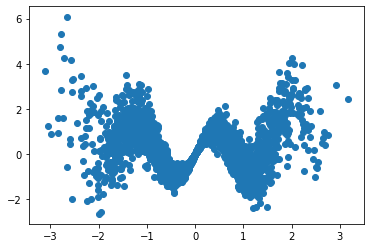

In [11]:
# Simulate data
num_obs = 3000
sd_true = .3
x, y = simulate_data(shape=(num_obs, 1), sd=sd_true, seed=0)

# Plot data
plt.scatter(x, y)
plt.show()

***

## Non-Bayesian Model

In [12]:
# Model (non-bayesian)
reg = tf.keras.regularizers.l2(0)
act = 'sigmoid'
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, kernel_regularizer=reg, activation=act),
    tf.keras.layers.Dense(2),
    tfp.layers.DistributionLambda(lambda t:
        # NOTE: `t[:, :1] != t[:, 0]` and `t[:, 1:] != t[:, 1]`.
        # This will be clear by inspecting the shapes.
        tfd.Normal(t[:, :1], centered_softplus(t[:, 1:]))
    )
])
    
# This needs to be run before `model.summary()`
# so that the input shape can be determined.
model(x);

In [13]:
# Define optimizer
opt = tf.keras.optimizers.Adam(learning_rate=.1)

# Compile model
model.compile(optimizer=opt, loss=neg_loglike)
        
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  16        
_________________________________________________________________
dense_1 (Dense)              multiple                  18        
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [14]:
print('Start time:', end=' ')
!date

# Fit the model
model.fit(x, y, epochs=512, batch_size=512, verbose=0)

print('End time:', end=' ')
!date

Start time: Thu Sep 19 11:05:42 PDT 2019
End time: Thu Sep 19 11:05:46 PDT 2019


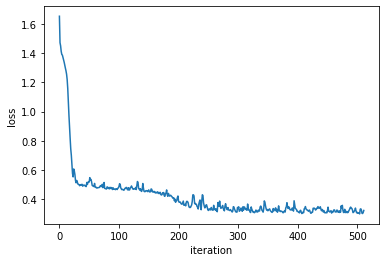

In [15]:
# Plot the loss history
plt.plot(model.history.history['loss'])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

In [16]:
# Create new locations for prediction
num_new_obs = 501
x_new = np.linspace(x.min(), x.max(), num_new_obs).reshape(-1, 1).astype('float32')
y_new = simulate_data(x_new, sd=sd_true, seed=1)[1].squeeze()

In [17]:
# Make predictions at new locations
preds = model(x_new)
preds_mean = preds.mean().numpy().squeeze()
preds_sd = preds.stddev().numpy().squeeze()
preds_lower = preds_mean - 1.96 * preds_sd
preds_upper = preds_mean + 1.96 * preds_sd

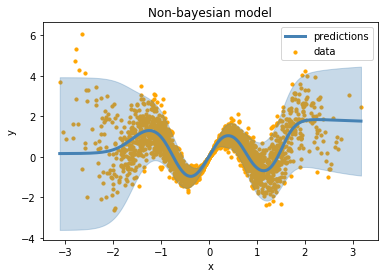

In [18]:
# Plot y vs x
plt.plot(x_new.squeeze(), preds_mean, label='predictions', zorder=2, lw=3, c='steelblue')
plt.fill_between(x_new.squeeze(), preds_lower, preds_upper, color='steelblue', alpha=.3, zorder=2)
plt.scatter(x.squeeze(), y.squeeze(), label='data', zorder=1, c='orange', s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Non-bayesian model')
plt.legend()
plt.show()

In [19]:
# Compute Coverage
coverage = np.mean((preds_lower < y_new) & (y_new < preds_upper))
print('Coverage for non-bayesian model: {}'.format(coverage))

Coverage for non-bayesian model: 0.9281437125748503


***

## Bayesian Model

In [20]:
# Bayesian model
bayes_model = tf.keras.Sequential([
    tfp.layers.DenseVariational(8,
                                make_default_dense_guide,
                                make_default_dense_prior,
                                activation='sigmoid',
                                kl_weight=1/num_obs),
    tfp.layers.DenseVariational(2,
                                make_default_dense_guide,
                                make_default_dense_prior,
                                kl_weight=1/num_obs),
    tfp.layers.DistributionLambda(lambda t:
        # NOTE: `t[:, :1] != t[:, 0]` and `t[:, 1:] != t[:, 1]`.
        # This will be clear by inspecting the shapes.
        tfd.Normal(t[..., :1], centered_softplus(t[..., 1:]))
    )
])

bayes_model(x);

In [21]:
# Define bayesian optimizer
bayes_opt = tf.keras.optimizers.Adam(.1)

# Compile model, with negative log likelihood as loss.
# Note that the DenseVariaional has info about the prior
# and guide. These will be incorporated into the total loss,
# just as the regularization terms are incorporated into
# the total loss when using a Dense layer.
bayes_model.compile(optimizer=bayes_opt, loss=neg_loglike)

# Print model summary
bayes_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari multiple                  32        
_________________________________________________________________
dense_variational_1 (DenseVa multiple                  36        
_________________________________________________________________
distribution_lambda_1 (Distr multiple                  0         
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________


In [22]:
print('Start time:', end=' ')
!date

# Fit the model
bayes_model.fit(x, y, epochs=512, batch_size=512, verbose=0)

print('End time:', end=' ')
!date

Start time: Thu Sep 19 11:05:47 PDT 2019
End time: Thu Sep 19 11:05:52 PDT 2019


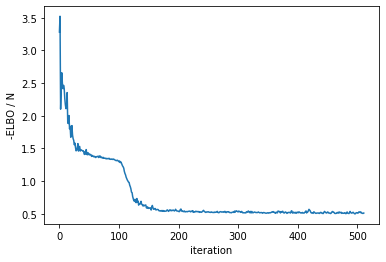

In [23]:
# Plot the ELBO history
plt.plot(bayes_model.history.history['loss'])
plt.xlabel('iteration')
plt.ylabel('-ELBO / N')
plt.show()

In [24]:
nsamps = 201
bayes_preds = np.stack([bayes_model.predict(x_new).squeeze() for _ in trange(nsamps)], axis=1)
bayes_preds_mean = bayes_preds.mean(1)
bayes_preds_lower = np.quantile(bayes_preds, .025, 1)
bayes_preds_upper = np.quantile(bayes_preds, .975, 1)


100%|██████████| 201/201 [00:09<00:00, 22.31it/s]


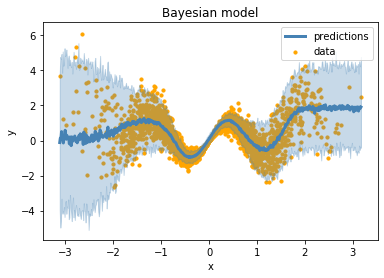

In [25]:
# Plot y vs x
plt.plot(x_new.squeeze(), bayes_preds_mean, label='predictions', zorder=2, lw=3, c='steelblue')
plt.fill_between(x_new.squeeze(), bayes_preds_lower, bayes_preds_upper, color='steelblue', alpha=.3, zorder=2)
plt.scatter(x.squeeze(), y.squeeze(), label='data', zorder=1, c='orange', s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian model')
plt.legend()
plt.show()

In [26]:
# Compute Coverage
bayes_coverage = np.mean((bayes_preds_lower < y_new) & (y_new < bayes_preds_upper))
print('Coverage for Bayesian model: {}'.format(bayes_coverage))

Coverage for Bayesian model: 0.9041916167664671


In [27]:
!date

Thu Sep 19 11:06:02 PDT 2019
